<a href="https://colab.research.google.com/github/juhumkwon/source_code/blob/main/%EB%B3%80%ED%98%95_%EC%98%A4%ED%86%A0%EC%9D%B8%EC%BD%94%EB%8D%94ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Epoch: 7 | recon_loss: 22.052433013916016 | latent_loss: 3.24591064453125


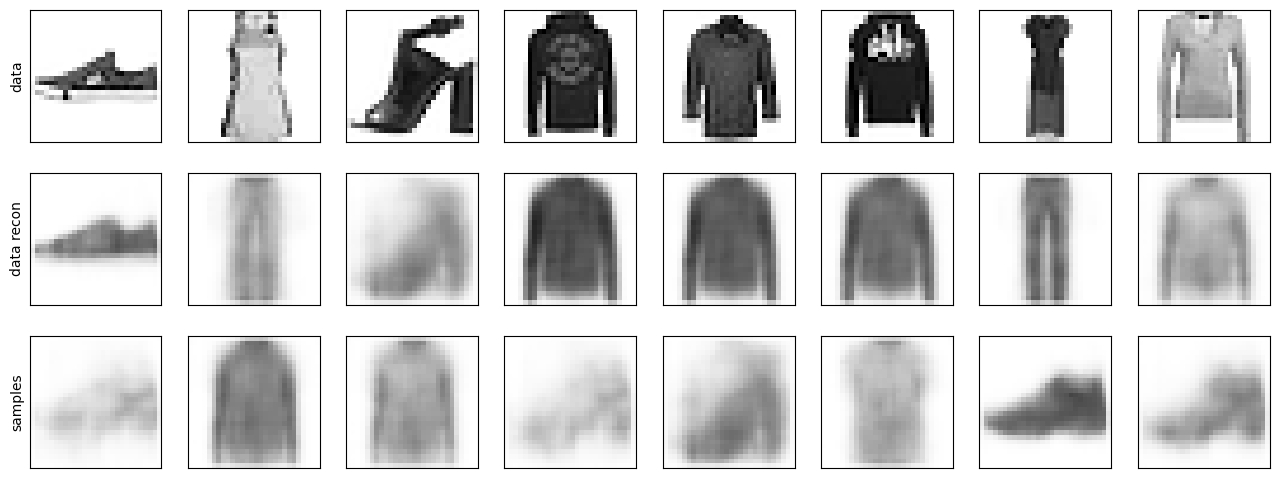

  0%|          | 0/117 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [10]:
#13.2.2 변형 오토인코더(Variational AutoEncoder)

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm
%matplotlib inline
from IPython import display
import pandas as pd
import tensorflow_probability as tfp
ds = tfp.distributions

TRAIN_BUF=60000
TEST_BUF=10000
BATCH_SIZE=512
N_TRAIN_BATCHES =int(TRAIN_BUF/BATCH_SIZE)
N_TEST_BATCHES = int(TEST_BUF/BATCH_SIZE)

(train_images, train_lebels), (test_images, test_lebels) = tf.keras.datasets.fashion_mnist.load_data()

train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype("float32") / 255.0
test_images = test_images.reshape(test_images.shape[0], 28, 28, 1).astype("float32") / 255.0

train_dataset = (
    tf.data.Dataset.from_tensor_slices(train_images)
    .shuffle(60000)
    .batch(512)
)
test_dataset = (
    tf.data.Dataset.from_tensor_slices(test_images)
    .shuffle(10000)
    .batch(512)
)

class VAE(tf.keras.Model):
    def __init__(self, **kwargs):
        super(VAE, self).__init__()
        self.__dict__.update(kwargs)

        self.enc = tf.keras.Sequential(self.enc)
        self.dec = tf.keras.Sequential(self.dec)

    def encode(self, x):
        mu, sigma = tf.split(self.enc(x), num_or_size_splits=2, axis=1)
        return ds.MultivariateNormalDiag(loc=mu, scale_diag=sigma)
    def reparameterize(self, mean, logvar):
        epsilon = tf.random.normal(shape=mean.shape)
        return epsilon * tf.exp(logvar * 0.5) + mean

    def reconstruct(self, x):
        mu, _ = tf.split(self.enc(x), num_or_size_splits=2, axis=1)
        return self.decode(mu)

    def decode(self, z):
        return self.dec(z)

    def loss_function(self, x):
        q_z = self.encode(x)
        z = q_z.sample()
        x_recon = self.decode(z)
        p_z = ds.MultivariateNormalDiag(
          loc=[0.] * z.shape[-1], scale_diag=[1.] * z.shape[-1]
          )
        kl_div = ds.kl_divergence(q_z, p_z)
        latent_loss = tf.reduce_mean(tf.maximum(kl_div, 0))
        recon_loss = tf.reduce_mean(tf.reduce_sum(tf.math.square(x - x_recon), axis=0))
        return recon_loss, latent_loss

    def gradients(self, x):
        with tf.GradientTape() as tape:
            loss = self.loss_function(x)
        return tape.gradient(loss, self.trainable_variables)

    @tf.function
    def train(self, train_x):
        gradients = self.gradients(train_x)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))

encoder = [
    tf.keras.layers.InputLayer(input_shape=(28,28,1)),
    tf.keras.layers.Conv2D(
        filters=32, kernel_size=3, strides=(2, 2), activation="relu"
    ),
    tf.keras.layers.Conv2D(
        filters=64, kernel_size=3, strides=(2, 2), activation="relu"
    ),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=2*2),
]

decoder = [
    tf.keras.layers.Dense(units=7 * 7 * 64, activation="relu"),
    tf.keras.layers.Reshape(target_shape=(7, 7, 64)),
    tf.keras.layers.Conv2DTranspose(
        filters=64, kernel_size=3, strides=(2, 2), padding="SAME", activation="relu"
    ),
    tf.keras.layers.Conv2DTranspose(
        filters=32, kernel_size=3, strides=(2, 2), padding="SAME", activation="relu"
    ),
    tf.keras.layers.Conv2DTranspose(
        filters=1, kernel_size=3, strides=(1, 1), padding="SAME", activation="sigmoid"
    ),
]

model = VAE(
    enc = encoder,
    dec = decoder,
    optimizer = tf.keras.optimizers.Adam(1e-3)
)

example_data = next(iter(test_dataset))
def plot_reconstruction(model, example_data, nex=8, zm=2):

    example_data_reconstructed = model.reconstruct(example_data)
    samples = model.decode(tf.random.normal(shape=(BATCH_SIZE, 2)))
    fig, axs = plt.subplots(ncols=nex, nrows=3, figsize=(zm * nex, zm * 3))
    for axi, (dat, lab) in enumerate(
        zip(
            [example_data, example_data_reconstructed, samples],
            ["data", "data recon", "samples"],
        )
    ):
        for ex in range(nex):
            axs[axi, ex].matshow(
                dat.numpy()[ex].squeeze(), cmap=plt.cm.Greys, vmin=0, vmax=1
            )
            axs[axi, ex].axes.get_xaxis().set_ticks([])
            axs[axi, ex].axes.get_yaxis().set_ticks([])
        axs[axi, 0].set_ylabel(lab)
    plt.show()

losses = pd.DataFrame(columns = ['recon_loss', 'latent_loss'])

n_epochs = 50

for epoch in range(n_epochs):
    for batch, train_x in tqdm(
        zip(range(N_TRAIN_BATCHES), train_dataset), total=N_TRAIN_BATCHES):
        model.train(train_x)
        loss = []

    for batch, test_x in tqdm(
        zip(range(N_TEST_BATCHES), test_dataset), total=N_TEST_BATCHES
):
        loss.append(model.loss_function(train_x))
    losses.loc[len(losses)] = np.mean(loss, axis=0)
    display.clear_output()
    print(
        "Epoch: {} | recon_loss: {} | latent_loss: {}".format(
            epoch, losses.recon_loss.values[-1], losses.latent_loss.values[-1]
        )
    )

    plot_reconstruction(model, example_data)

